This work is based on the following [paper](https://haoyfan.github.io/papers/SemiTime_ICASSP2021.pdf)

# Import

In [ ]:
%pip install torchmetrics --quiet
import math
import copy
import random
import numpy        as np
import pandas       as pd
import torch
import torch.nn     as nn
import torchmetrics
from torch.nn                 import functional         as F
from matplotlib               import pyplot             as plt
from numpy                    import savetxt, loadtxt
from sklearn.model_selection  import train_test_split
from torch.utils.data         import Dataset, DataLoader
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics          import classification_report, confusion_matrix
from tabulate                 import tabulate

print("Libraries imported.")

Libraries imported.


# Dataset

Datasets are taken from this github repository: https://github.com/haoyfan/SemiTime/tree/main/datasets \
Choose a dataset by assigning one of the following strings to *dataset_name* variable: \
* CricketX (12 classes)
* InsectWingbeatSound (8 classes) \

In [ ]:
dataset_name = "InsectWingbeatSound"

if dataset_name == "CricketX":
    ALL_TEST_url = 'https://raw.githubusercontent.com/haoyfan/SemiTime/main/datasets/CricketX/CricketX_TEST.tsv'
    ALL_TRAIN_url = 'https://raw.githubusercontent.com/haoyfan/SemiTime/main/datasets/CricketX/CricketX_TRAIN.tsv'
elif dataset_name == "InsectWingbeatSound":
    ALL_TEST_url = 'https://raw.githubusercontent.com/haoyfan/SemiTime/main/datasets/InsectWingbeatSound/InsectWingbeatSound_TEST.tsv'
    ALL_TRAIN_url = 'https://raw.githubusercontent.com/haoyfan/SemiTime/main/datasets/InsectWingbeatSound/InsectWingbeatSound_TRAIN.tsv'

ALL_TEST_df = pd.read_table(ALL_TEST_url, header=None)
ALL_TRAIN_df = pd.read_table(ALL_TRAIN_url, header=None)

To reduce the complexity of the task, a subset of classes is taken. Contextually, a subset of rows is maintained.

In [ ]:
Label_TEST = ALL_TEST_df.loc[:, 0].values.tolist()
desired_num_classes = 4
# In these datasets, classes are labeled from 1
desired_classes = np.arange(1, desired_num_classes+1) # list of desired classes
classes_np = np.array(unique_labels(Label_TEST)) # list of all classes
list_classes_to_delete = list(set(classes_np) - set(desired_classes)) # list of retained classes

In [ ]:
print(ALL_TRAIN_df.shape) 
print(ALL_TEST_df.shape)
# Find rows indexes to be deleted
target_indexes = []
for i in range(ALL_TRAIN_df.shape[0]):
    if ALL_TRAIN_df.loc[i, 0] in list_classes_to_delete:
        target_indexes.append(i)
# Delete train dataset rows from indexes  
ALL_TRAIN_df.drop(target_indexes, inplace=True)
# Find rows indexes to be deleted
target_indexes = []
for i in range(ALL_TEST_df.shape[0]):
    if ALL_TEST_df.loc[i, 0] in list_classes_to_delete:
        target_indexes.append(i)
# Delete test dataset rows from indexes  
ALL_TEST_df.drop(target_indexes, inplace=True)
print(ALL_TRAIN_df.shape)
print(ALL_TEST_df.shape)

(220, 257)
(1980, 257)
(80, 257)
(720, 257)


In [ ]:
# Convert from Pandas Dataframe to list
Label_TEST = ALL_TEST_df.loc[:, 0].values.tolist()
Data_TEST = ALL_TEST_df.loc[:, 1:].values.tolist()
Label_TRAIN = ALL_TRAIN_df.loc[:, 0].values.tolist()
Data_TRAIN = ALL_TRAIN_df.loc[:, 1:].values.tolist()

In [ ]:
# Print some information about the dataset that will be used
num_classes = len(unique_labels(Label_TEST))
class_names = list(map(str, (np.arange(0, num_classes).tolist())))
print(class_names)
print("Number of classes: %d" %(num_classes))
print("Labels in Test Set. Number of samples: %d." %(len(Label_TEST)))
print("Data in Test Set. Number of samples: %d. Number of features: %d" %(len(Data_TEST), len(Data_TEST[0])))
print("Labels in Train Set. Number of samples: %d." %(len(Label_TRAIN)))
print("Data in Train Set. Number of samples: %d. Number of features: %d" %(len(Data_TRAIN), len(Data_TRAIN[0])))

['0', '1', '2', '3']
Number of classes: 4
Labels in Test Set. Number of samples: 720.
Data in Test Set. Number of samples: 720. Number of features: 256
Labels in Train Set. Number of samples: 80.
Data in Train Set. Number of samples: 80. Number of features: 256


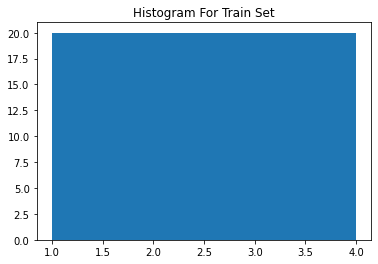

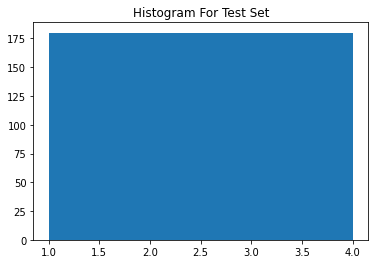

In [ ]:
# Plotting the histogram of the labels to determine whether the dataset is balanced
plt.figure(1)
plt.title("Histogram For Train Set")
plt.hist(Label_TRAIN, num_classes)
plt.figure(2)
plt.title("Histogram For Test Set")
plt.hist(Label_TEST, num_classes)
plt.show()

In [ ]:
# Convert dataset from list to numpy
ALL_X_TRAIN_np = np.array(Data_TRAIN)
ALL_y_TRAIN_np = np.array(Label_TRAIN) - 1 # with this classes are labeled from 0
ALL_X_TEST_np = np.array(Data_TEST)
ALL_y_TEST_np = np.array(Label_TEST) - 1 # with this classes are labeled from 0

# convert dataset from numpy to torch
# X data are reshape to allow 1D convolutional operation
ALL_X_TRAIN_torch = torch.tensor(ALL_X_TRAIN_np)
ALL_X_TRAIN_torch = torch.reshape(ALL_X_TRAIN_torch, (ALL_X_TRAIN_torch.shape[0], 1, ALL_X_TRAIN_torch.shape[1]))
ALL_X_TRAIN_torch = ALL_X_TRAIN_torch.to(torch.float32)
ALL_y_TRAIN_torch = torch.from_numpy(ALL_y_TRAIN_np)

ALL_X_TEST_torch = torch.tensor(ALL_X_TEST_np)
ALL_X_TEST_torch = torch.reshape(ALL_X_TEST_torch, (ALL_X_TEST_torch.shape[0], 1, ALL_X_TEST_torch.shape[1]))
ALL_X_TEST_torch = ALL_X_TEST_torch.to(torch.float32)
ALL_y_TEST_torch = torch.from_numpy(ALL_y_TEST_np)

For model training the whole training set is used as unlabeled data while a subset of it is used as labeled data. \\
For this reason, the following function that returns a subset of the entire dataset based on the *label_ratio* value has been implemented. \\


In [ ]:
def labledDataset(label_ratio):
    # Numpy Arrays
    num_of_ALL_sample_TRAIN = ALL_X_TRAIN_np.shape[0]
    num_of_LABELED_sample_TRAIN = math.floor(num_of_ALL_sample_TRAIN*label_ratio)
    idx = random.sample(range(num_of_ALL_sample_TRAIN), num_of_LABELED_sample_TRAIN)
    labeled_X_TRAIN_np = ALL_X_TRAIN_np[idx, :] 
    labeled_y_TRAIN_np = np.array(Label_TRAIN)[idx] - 1
    # Torch Tensor
    labeled_X_TRAIN_torch = torch.tensor(labeled_X_TRAIN_np)
    labeled_X_TRAIN_torch = torch.reshape(labeled_X_TRAIN_torch, (labeled_X_TRAIN_torch.shape[0], 1, labeled_X_TRAIN_torch.shape[1]))
    labeled_X_TRAIN_torch = labeled_X_TRAIN_torch.to(torch.float32)
    labeled_y_TRAIN_torch = torch.from_numpy(labeled_y_TRAIN_np)

    return [labeled_X_TRAIN_torch, labeled_y_TRAIN_torch]

# Dataset Class for DataLoader

In [ ]:
class TimeSeriesClassificationDataset(Dataset):
    def __init__(self, data, label):
        assert data.shape[0] == label.shape[0]
        self.num_samples = data.shape[0]
        self.data = []
        for row_idx in range(data.shape[0]):
            item = {'inputs': data[row_idx], 'outputs': label[row_idx]}
            self.data.append(item)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# Temporal Relational Segment Sampling Module

For each segment passed, one positive and one negative segment are sampled given *alpha* value. \\
* *alpha* is past-future segment split ratio (it determines the past segment length)
* *s* are past segments
* *s_plus* are positive future segments
* *s_minus* are negative future segments

In [ ]:
def temporalRelationalSegmentSamplingModule(segments, alpha):
  s_i_length = math.floor(segments.shape[1]*alpha)
  # A past segment is given by the first part of the segment
  s = segments[:, 0 : s_i_length]
  # A positive future segment is given by the second part of the segment
  s_plus = segments[:, s_i_length:]
  # For each past segment, sample a negative future segment
  for j in range(segments.shape[0]):
    indices = np.arange(0,segments.shape[0]).tolist()
    # A negative future segment is given by any segment other than 
    # the successive temporal segment of the given past segment
    indices.remove(j)
    sampled_idx = random.choice(indices)
    tmp = segments[sampled_idx, s_i_length:]
    tmp = torch.reshape(tmp, (1, segments.shape[1] - s_i_length))
    if j == 0:
      s_minus = tmp
    else:
      s_minus = torch.cat((s_minus, tmp), dim=0)
  return [s, s_plus, s_minus]

This function uses the temporalRelationalSegmentSamplingModule return [s, s_plus, s_minus] to create a dataset for the self-supervised temporal relationship prediction module.

In [ ]:
def createDatasetUsingSamplingModule(s, s_plus, s_minus):
    X_plus = torch.cat((s, s_plus), dim = 1)
    y_plus = torch.ones(s.shape[0])
    X_minus = torch.cat((s, s_minus), dim = 1)
    y_minus = torch.zeros(s.shape[0])
    
    X = X_plus[0]
    X = torch.reshape(X, (1, X_plus.shape[1]))
    y = y_plus[0]
    y = torch.reshape(y, (1, 1))

    X = torch.cat((X, torch.reshape(X_minus[1], (1, X_minus.shape[1]))), dim = 0)
    y = torch.cat((y, torch.reshape(y_minus[1], (1, 1))), dim = 0)
    
    # Reshape to allow 1D convolutional operation and shuffle
    for i in range(1, X_plus.shape[0]):
        X = torch.cat((X, torch.reshape(X_plus[i], (1, X_plus.shape[1]))), dim = 0)
        y = torch.cat((y, torch.reshape(y_plus[1], (1, 1))), dim = 0)
        X = torch.cat((X, torch.reshape(X_minus[i], (1, X_minus.shape[1]))), dim = 0)
        y = torch.cat((y, torch.reshape(y_minus[1], (1, 1))), dim = 0)
    return [X, y]

This function shuffles and returns self-supervised dataset for training phase. Moreover, it reshapes dataset to allow 1D convolutional operation.

In [ ]:
# SSTRP = Self-Supervised Temporal Relation Prediction
def shuffleAndReshapeDataset(alpha):
    segments_to_separate = torch.reshape(ALL_X_TRAIN_torch, (ALL_X_TRAIN_torch.shape[0], ALL_X_TRAIN_torch.shape[2]))
    s, s_plus, s_minus = temporalRelationalSegmentSamplingModule(segments_to_separate, alpha)
    X_for_SSTRP_temp, y_for_SSTRP_temp = createDatasetUsingSamplingModule(s, s_plus, s_minus)
    X_for_SSTRP_temp = torch.reshape(X_for_SSTRP_temp, (X_for_SSTRP_temp.shape[0], 1, X_for_SSTRP_temp.shape[1]))
    y_for_SSTRP_temp = torch.squeeze(y_for_SSTRP_temp).to(torch.int64)
    # Suffle
    y_for_SSTRP_temp = torch.reshape(y_for_SSTRP_temp, (y_for_SSTRP_temp.shape[0], 1,  1))
    dataset_for_self_supervised = torch.cat((X_for_SSTRP_temp, y_for_SSTRP_temp), dim = 2)
    dataset_for_self_supervised = dataset_for_self_supervised[torch.randperm(dataset_for_self_supervised.size()[0])]
    X_for_SSTRP = dataset_for_self_supervised[:, : , 0:-1]
    y_for_SSTRP = dataset_for_self_supervised[:, : , -1]
    y_for_SSTRP = torch.squeeze(y_for_SSTRP).to(torch.int64)
    return [X_for_SSTRP, y_for_SSTRP]

# Model Definition

## Encoder Backbone

Encoder Backbone Module is composed by simple 4-layer 1D convolutional neural network with ReLU activation function and batch normalization.

In [ ]:
class EncoderBackbone(nn.Module):
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv1d(1, 1, 1, stride = 1)
        self.bn1 = nn.BatchNorm1d(1)
        self.conv2 = nn.Conv1d(1, 1, 1, stride = 1)
        self.bn2 = nn.BatchNorm1d(1)
        self.conv3 = nn.Conv1d(1, 1, 1, stride = 1)
        self.bn3 = nn.BatchNorm1d(1)
        self.conv4 = nn.Conv1d(1, 1, 1, stride = 1)
        self.bn4 = nn.BatchNorm1d(1)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        y = F.relu(self.bn3(self.conv3(y)))
        y = F.relu(self.bn4(self.conv4(y)))
        return y

## Classification Head

Classification Head Module is composed by single linear layer.

In [ ]:
class ClassificationHead(nn.Module): 
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        y = self.fc(x)
        return y

## Relation Head

Relation Head Module is composed by a two-layer fully-connected networks with 256 hidden neurons.

In [ ]:
class RelationHead(nn.Module): 
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        y = self.fc1(x)
        y = self.fc2(y)
        return y

## Supervised Classification Module

Supervised Classification Module is composed by a concatenation of Encoder Backbone Module and Classification Head Module.

In [ ]:
class SupervisedClassification(nn.Module): 
    def __init__(self, input_dim, num_classes): 
        super().__init__()
        self.EncoderBackboneModule = EncoderBackbone()
        self.ClassificationHeadModule = ClassificationHead(input_dim, num_classes)

    def forward(self, x):
        y = self.EncoderBackboneModule(x)
        y = torch.reshape(y, (y.shape[0], y.shape[2]))
        y = self.ClassificationHeadModule(y)
        return y

## Self-Supervised Temporal Relation Prediction Module

Self-Supervised Temporal Relation Prediction Module is composed by a concatenation of Encoder Backbone Module and Relation Head Module.

In [ ]:
class SelfSupervisedTemporalRelationPrediction(nn.Module): 
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.EncoderBackboneModule = EncoderBackbone()
        self.RelationHeadModule = RelationHead(in_features, num_classes)

    def forward(self, x):
        y = self.EncoderBackboneModule(x)
        y = torch.reshape(y, (y.shape[0], y.shape[2]))
        y = self.RelationHeadModule(y)
        return y

# Define Trainers

## Supervised Trainer

Trainer for Supervised Classification Module.



In [ ]:
class Supervised_TimeSeriesClassificationTrainer():
    def __init__(self, SC_Model, supervised_loss_fun, optimizer, device, num_classes):
        self.SC_Model = SC_Model
        self.supervised_loss_fun = supervised_loss_fun
        self.optimizer = optimizer
        self.device = device
        self.num_classes = num_classes
        self.acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = num_classes).to(device)

    def train(self, labeled_dataset, epochs=1000):
        assert epochs > 1 and isinstance(epochs, int)
        # print('Training...')
        train_loss = 0.0
        for epoch in range(epochs):
            self.SC_Model.train()
            for step, sample in enumerate(labeled_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                xb, yb = inputs.to(device), labels.to(device)       
                self.optimizer.zero_grad()
                # Embedding of labeled inputs
                z_i = self.SC_Model.EncoderBackboneModule(xb)
                z_i = torch.reshape(z_i, (z_i.shape[0], z_i.shape[2]))
                # Label classification
                p_i = self.SC_Model.ClassificationHeadModule(z_i)
                # Cross-entropy loss
                l = self.supervised_loss_fun(p_i, yb)
                l.backward()
                # Update models
                self.optimizer.step()
                # print(f'Accuracy at epoch {epoch}: {self.accuracy(xb, yb)}')
            self.SC_Model.eval()
        # print('... Done!')

    def accuracy(self, X, y):
        ypred = self.SC_Model(X)
        _ = self.acc(ypred, y)
        return self.acc.compute()

## Semi-Supervised Trainer

Trainer for Semi-Supervised (or Supervised Classification Module and Self-Supervised Temporal Relation Prediction Module).

In [ ]:
class Semi_Supervised_TimeSeriesClassificationTrainer():
    def __init__(self, SC_Model, SSTRP_Model, supervised_loss_fun, self_supervised_loss_fun, alpha, s_i_length, supervised_opt, self_supervised_opt, device, num_classes):
        self.SC_Model = SC_Model
        self.SSTRP_Model = SSTRP_Model
        self.supervised_loss_fun = supervised_loss_fun
        self.self_supervised_loss_fun = self_supervised_loss_fun
        self.supervised_opt = supervised_opt
        self.self_supervised_opt = self_supervised_opt
        self.device = device
        self.num_classes = num_classes
        self.acc = torchmetrics.Accuracy(task = 'multiclass', num_classes = num_classes).to(device)
        self.T = s_i_length # segment length
        self.B = math.floor(self.T*alpha) # past segment length

    def train(self, labeled_dataset, unlabeled_loader, epochs=1000):
        assert epochs > 1 and isinstance(epochs, int)
        train_loss = 0.0
        for epoch in range(epochs):
            self.SC_Model.train()
            for step, sample in enumerate(labeled_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']
                xb, yb = inputs.to(device), labels.to(device)       
                self.supervised_opt.zero_grad()
                # Embedding of labeled inputs
                z_i = self.SC_Model.EncoderBackboneModule(xb)
                z_i = torch.reshape(z_i, (z_i.shape[0], z_i.shape[2]))
                # Label classification
                p_i = self.SC_Model.ClassificationHeadModule(z_i)
                # Cross-entropy loss
                l = self.supervised_loss_fun(p_i, yb)
                l.backward()
                # Update models
                self.supervised_opt.step()
            # Share updated weights with Encoder Backbone Module of
            # Self-Supervised Temporal Relation Prediction Module
            self.SSTRP_Model.EncoderBackboneModule = copy.deepcopy(self.SC_Model.EncoderBackboneModule)
            self.SSTRP_Model.train()
            for step, sample in enumerate(unlabeled_loader):
              inputs = sample['inputs']
              labels = sample['outputs']
              t, yb = inputs.to(device), labels.to(device) 
              self.self_supervised_opt.zero_grad()
              # Embed
              s = t[:, :, 0:self.B]
              z = self.SSTRP_Model.EncoderBackboneModule(s)
              s_plus_or_minus = t[:, :, self.B:]
              z_plus_or_minus = self.SSTRP_Model.EncoderBackboneModule(s_plus_or_minus)
              # Reshape
              z = torch.reshape(z, (z.shape[0], z.shape[2]))
              z_plus_or_minus = torch.reshape(z_plus_or_minus, (z_plus_or_minus.shape[0], z_plus_or_minus.shape[2]))
              # Cat
              h = torch.cat((z, z_plus_or_minus), dim = 1)
              # Positive and Negative segment predictions
              p = self.SSTRP_Model.RelationHeadModule(h)
              # Binary Cross-entropy loss
              l = self.self_supervised_loss_fun(p, yb)
              l.backward()
              # Update model
              self.self_supervised_opt.step()
            self.SSTRP_Model.eval()
            # Share updated weights with Encoder Backbone Module of
            # Supervised Classification Module
            self.SC_Model.EncoderBackboneModule = copy.deepcopy(self.SSTRP_Model.EncoderBackboneModule)

    def accuracy(self, X, y):
        ypred = self.SC_Model(X)
        _ = self.acc(ypred, y)
        return self.acc.compute()

# Supervised Mini-batch Training

This function trains Supervised Classification Module **without** using Self-Supervised Temporal Relation Prediction Module.

In [ ]:
def SupervisedMiniBatchTraining(batch_size, epochs, lr, labeled_X_TRAIN_torch, labeled_y_TRAIN_torch):
    # Model
    SC_Model = SupervisedClassification(labeled_X_TRAIN_torch.shape[2], num_classes).to(device)
    # Data Loader 
    labeled_loader = DataLoader(TimeSeriesClassificationDataset(labeled_X_TRAIN_torch.to(device), labeled_y_TRAIN_torch.to(device)), batch_size=batch_size)
    # Loss function and Optimizer
    supervised_loss_fun = nn.CrossEntropyLoss()
    supervised_opt = torch.optim.Adam(SC_Model.parameters(), lr=lr)
    # Training
    supervised_trainer = Supervised_TimeSeriesClassificationTrainer(SC_Model, supervised_loss_fun, supervised_opt, device, num_classes )
    supervised_trainer.train(labeled_loader, epochs=epochs)

    return SC_Model

# SemiTime Mini-batch Training

This function trains Supervised Classification Module **using** Self-Supervised Temporal Relation Prediction Module

In [ ]:
def SemiTimeMiniBatchTraining(batch_size, epochs, lr, X_for_SSTRP, y_for_SSTRP, alpha):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Models
    SemiSupervised_Model = SupervisedClassification(ALL_X_TRAIN_torch.shape[2], num_classes).to(device)
    s_i_lenght = X_for_SSTRP.shape[2]
    SSTRP_Model = SelfSupervisedTemporalRelationPrediction(s_i_lenght, 2).to(device)
    # Data Loader s
    X_for_SSTRP = torch.reshape(X_for_SSTRP, (X_for_SSTRP.shape[0], 1, X_for_SSTRP.shape[2]))
    unlabeled_loader = DataLoader(TimeSeriesClassificationDataset(X_for_SSTRP.to(device), y_for_SSTRP.to(device)), batch_size=batch_size)
    SemiSupervised_labeled_loader = DataLoader(TimeSeriesClassificationDataset(labeled_X_TRAIN_torch.to(device), labeled_y_TRAIN_torch.to(device)), batch_size=batch_size)
    # Loss functions and Optimizers
    self_supervised_loss_fun = nn.CrossEntropyLoss()
    self_supervised_opt = torch.optim.Adam(SSTRP_Model.parameters(), lr=lr)
    semi_supervised_loss_fun = nn.CrossEntropyLoss()
    semi_supervised_opt = torch.optim.Adam(SemiSupervised_Model.parameters(), lr=lr)
    # Training
    semi_supervised_trainer = Semi_Supervised_TimeSeriesClassificationTrainer(SemiSupervised_Model, SSTRP_Model, semi_supervised_loss_fun, self_supervised_loss_fun, alpha, s_i_lenght, semi_supervised_opt, self_supervised_opt, device, num_classes)
    semi_supervised_trainer.train( SemiSupervised_labeled_loader, unlabeled_loader, epochs = epochs )

    return SemiSupervised_Model

# Evaluation Function

In [ ]:
def AccuracyEvaluation(model, X, y_true):
    y_test = y_true.cpu().detach().numpy()
    y_pred = torch.argmax(model(X.to(device)), dim=1).cpu().detach().numpy()
    return classification_report(y_test, y_pred,  output_dict=True, labels=None, target_names=class_names, digits=3)['accuracy']

# Test Classification Accuracy (%, averages of 10 runs)

In [ ]:
label_ratio_list = [0.1,0.2, 0.4, 1] # possible label ratios
alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # possible alpha values
number_of_runs = 10
epochs = 100
batch_size = 128
lr = 0.01
supervised_accuracy_np = np.empty([len(label_ratio_list), len(alpha_list)])
semi_supervised_accuracy_np = np.empty([len(label_ratio_list), len(alpha_list)])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# For each label ratio, alpha value and run, train Supervised and Semi-Supervised Modules.
for label_ratio_idx in range(len(label_ratio_list)):
    # Supervised dataset
    labeled_X_TRAIN_torch, labeled_y_TRAIN_torch = labledDataset(label_ratio_list[label_ratio_idx])
    for alpha_idx in range(len(alpha_list)):
        print(label_ratio_idx, alpha_idx)
        # Self-Supervised Dataset
        X_for_SSTRP, y_for_SSTRP = shuffleAndReshapeDataset(alpha_list[alpha_idx])
        supervised_accuracy = []
        semi_supervised_accuracy = []
        for run_idx in range(number_of_runs):
            # Supervised Model instantiation and training
            SC_Model = SupervisedMiniBatchTraining(batch_size, epochs, lr, labeled_X_TRAIN_torch, labeled_y_TRAIN_torch)
            # Supervised Model Evaluation on Test set
            SC_accuracy = AccuracyEvaluation(SC_Model, ALL_X_TEST_torch, ALL_y_TEST_torch)
            supervised_accuracy.append(SC_accuracy)
            # Semi-Supervised Model instantiation and training
            SemiSupervised_Model = SemiTimeMiniBatchTraining(batch_size, epochs, lr, X_for_SSTRP, y_for_SSTRP, alpha_list[alpha_idx])
            # Semi-Supervised Model Evaluation on Test set
            SS_accuracy = AccuracyEvaluation(SemiSupervised_Model, ALL_X_TEST_torch, ALL_y_TEST_torch)
            semi_supervised_accuracy.append(SS_accuracy)
        # For each label ratio and alpha value compute average accuracy on Test Set
        supervised_accuracy_np[label_ratio_idx][alpha_idx] = sum(supervised_accuracy) / number_of_runs
        semi_supervised_accuracy_np[label_ratio_idx][alpha_idx] = sum(semi_supervised_accuracy) / number_of_runs

In [ ]:
def highlight_accuracy(x):
    df = x.copy()
    df.loc[:,:] = 'background-color: ""'
    for i in range(len(label_ratio_list)):
        for j in range(len(alpha_list)):
            if x.iloc[i,j] > supervised_accuracy_np[i, j]:
                df.iloc[i,j] = 'background-color: green; color: white'
            else:
                df.iloc[i,j] = 'background-color: red; color: white'
    return df  

Show differences between Supervised and SemiTime Model accuracy on Test set after training phase

In [ ]:
supervised_accuracy_DF = pd.DataFrame(supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
supervised_accuracy_DF

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.743611,0.720417,0.797361,0.771111,0.792361,0.759167,0.674167,0.785556,0.799167
0.2,0.701944,0.665278,0.659861,0.677222,0.720000,0.668056,0.752639,0.691667,0.716111
0.4,0.717361,0.762917,0.817639,0.859444,0.804306,0.850694,0.801528,0.771806,0.699306
1.0,0.814306,0.734444,0.896806,0.872639,0.829444,0.905278,0.659167,0.838750,0.836528


In [ ]:
semi_supervised_accuracy_DF = pd.DataFrame(semi_supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
semi_supervised_accuracy_DF.style.apply(highlight_accuracy, axis=None)

,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000
0.100000,0.796250,0.765833,0.798056,0.776528,0.792500,0.790139,0.655972,0.744583,0.579722
0.200000,0.758333,0.748056,0.778750,0.759306,0.754028,0.755278,0.636944,0.722778,0.680833
0.400000,0.830972,0.852778,0.849861,0.817083,0.836111,0.862361,0.815694,0.777778,0.856389
1.000000,0.867361,0.892917,0.909028,0.880139,0.842917,0.788889,0.894583,0.904444,0.754583


# Saved Results

Average test accuracy on two given dataset is saved on my personal ghitub repository: https://github.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction

Supervised accuracy on CricketX Dataset: https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Supervised_accuracy_CricketX.csv \\
Semi Supervised accuracy on CricketX Dataset: https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Semi_Supervised_accuracy_CricketX.csv \\
Supervised accuracy on InsectWingbeatSound Dataset: https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Supervised_accuracy_InsectWingbeatSound.csv
Semi Supervised accuracy on InsectWingbeatSound Dataset: https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Semi_Supervised_accuracy_InsectWingbeatSound.csv \\

Test classification accuracy (%, averages of 10 runs) for supervised and semi-supervised learning on two given datasets. \\
Each **row** represents a different *label ratio*. \\
Each **column** represent a different *alpha* value.

## On CricketX Dataset

In [ ]:
def highlight_accuracy_CricketX(x):
    df = x.copy()
    df.loc[:,:] = 'background-color: ""'
    for i in range(len(label_ratio_list)):
        for j in range(len(alpha_list)):
            if x.iloc[i,j] > CricketX_supervised_accuracy_np[i, j]:
                df.iloc[i,j] = 'background-color: green; color: white'
            else:
                df.iloc[i,j] = 'background-color: red; color: white'
    return df  

### Accuracy using Supervised Model

In [ ]:
CricketX_supervised_accuracy_np = loadtxt('https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Supervised_accuracy_CricketX.csv', delimiter=' ')
CricketX_supervised_accuracy_DF = pd.DataFrame(CricketX_supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
CricketX_supervised_accuracy_DF

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.520492,0.516393,0.533607,0.557377,0.530328,0.479508,0.518852,0.543443,0.422951
0.2,0.565574,0.555738,0.479508,0.531967,0.468852,0.594262,0.622131,0.523770,0.533607
0.4,0.622951,0.556557,0.622951,0.638525,0.596721,0.559016,0.634426,0.585246,0.630328
1.0,0.687705,0.593443,0.553279,0.627049,0.609836,0.570492,0.601639,0.560656,0.611475


### Accuracy using Semi-Supervised Model

*Green Background*: Semi-Supervised Model Accuracy > Supervised Model Accuracy \\
*Red Background*: Semi-Supervised Model Accuracy <= Supervised Model Accuracy

In [ ]:
CricketX_semi_supervised_accuracy_np = loadtxt('https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/1b2a29d4deeadd74ad1f3270dc8a5af76fb8a6db/Results/Semi_Supervised_accuracy_CricketX.csv', delimiter=' ')
CricketX_semi_supervised_accuracy_DF = pd.DataFrame(CricketX_semi_supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
CricketX_semi_supervised_accuracy_DF.style.apply(highlight_accuracy_CricketX, axis=None)

,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000
0.100000,0.513115,0.517213,0.520492,0.549180,0.518852,0.527869,0.531967,0.484426,0.536066
0.200000,0.640164,0.580328,0.581148,0.564754,0.552459,0.567213,0.588525,0.568033,0.586885
0.400000,0.655738,0.678689,0.667213,0.641803,0.654098,0.632787,0.642623,0.650000,0.623770
1.000000,0.739344,0.694262,0.697541,0.682787,0.727049,0.704918,0.716393,0.703279,0.732787


## On InsectWingbeatSound

In [ ]:
def highlight_accuracy_InsectWingbeatSound(x):
    df = x.copy()
    df.loc[:,:] = 'background-color: ""'
    for i in range(len(label_ratio_list)):
        for j in range(len(alpha_list)):
            if x.iloc[i,j] > InsectWingbeatSound_supervised_accuracy_np[i, j]:
                df.iloc[i,j] = 'background-color: green; color: white'
            else:
                df.iloc[i,j] = 'background-color: red; color: white'
    return df  

### Accuracy using Supervised Model

In [ ]:
InsectWingbeatSound_supervised_accuracy_np = loadtxt('https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Supervised_accuracy_InsectWingbeatSound.csv', delimiter=' ')
InsectWingbeatSound_supervised_accuracy_DF = pd.DataFrame(InsectWingbeatSound_supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
InsectWingbeatSound_supervised_accuracy_DF

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0.1,0.743611,0.720417,0.797361,0.771111,0.792361,0.759167,0.674167,0.785556,0.799167
0.2,0.701944,0.665278,0.659861,0.677222,0.720000,0.668056,0.752639,0.691667,0.716111
0.4,0.717361,0.762917,0.817639,0.859444,0.804306,0.850694,0.801528,0.771806,0.699306
1.0,0.814306,0.734444,0.896806,0.872639,0.829444,0.905278,0.659167,0.838750,0.836528


### Accuracy using Semi-Supervised Model

Green Background: Semi-Supervised Model Accuracy > Supervised Model Accuracy \\
Red Background: Semi-Supervised Model Accuracy <= Supervised Model Accuracy

In [ ]:
InsectWingbeatSound_semi_supervised_accuracy_np = loadtxt('https://raw.githubusercontent.com/AlessandroPaglialunga1997/Semi-Supervised-Time-Series-Classification-by-Temporal-Relation-Prediction/main/Results/Semi_Supervised_accuracy_InsectWingbeatSound.csv', delimiter=' ')
InsectWingbeatSound_semi_supervised_accuracy_DF = pd.DataFrame(InsectWingbeatSound_semi_supervised_accuracy_np, columns=alpha_list, index=label_ratio_list)
InsectWingbeatSound_semi_supervised_accuracy_DF.style.apply(highlight_accuracy_InsectWingbeatSound, axis=None)

,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000
0.100000,0.796250,0.765833,0.798056,0.776528,0.792500,0.790139,0.655972,0.744583,0.579722
0.200000,0.758333,0.748056,0.778750,0.759306,0.754028,0.755278,0.636944,0.722778,0.680833
0.400000,0.830972,0.852778,0.849861,0.817083,0.836111,0.862361,0.815694,0.777778,0.856389
1.000000,0.867361,0.892917,0.909028,0.880139,0.842917,0.788889,0.894583,0.904444,0.754583
